# $fcc$ calculations

This notebook deals with obtaining Sentinel 2 data from before and after the fire. We assume:
* the fire perimeter is available, and 
* we know the date the fire originated.

The code will download a median composite of band reflectance for the 15 days before the start of the fire, and a similar composite of the reflectance 15 days after the fire. These two can then be used to calculate $fcc$

## Downloading data from GEE

We have a simple script to download data from GEE. Here, I assume that we have a geojson file ([`data/Historic_Perimeters_2019.geojson`](data/Historic_Perimeters_2019.geojson)) present that contains the geometry of the fire perimeter as well as some indication of the earliest day of burn. **This is just an example**

The following code snippet will take a while, and it is assumed that you can call the Python EarthEngine bindings in your installation. Once the snippet finishes (it will print a message), you can see the downloaded files in the `s2_data` folder.

For each fire, you get two GeoTIFF files that are clipped to the extent of the fire perimeter (plus some additional 250m buffering). Both files contain the following Sentinel 2 bands in this order:
`sel_bands = ["B2", "B3", "B4", "B5", "B6", "B7", "B8", "B11", "B12"]`

In [1]:
import warnings
import numpy as np
import json
import datetime
import multiprocessing
from osgeo import gdal
import matplotlib.pyplot as plt
gdal.SetConfigOption('CPL_LOG', '/dev/null')

In [2]:


from gee_grab import getResult

# Let's open the geojson file with some fires
with open("data/Historic_Perimeters_2019.geojson", "r") as fp:
    db = json.load(fp)

# Loop through the fires and download the images
print(f"I have a total of {len(db['features'])} fires")
print("I am only downloading 10 though....")
# Note that I only download the first 10 fires [:10]
fires = [x for x in db["features"][:10]]
geometries = [x["geometry"] for x in db["features"][:10]]
# I am not sure whether the datecurrent field relates to the fire data, so
# subract 10 days? Needs checking
burn_dates = [
    datetime.datetime.strptime(x["properties"]["datecurrent"], "%Y-%m-%dT%H:%M:%SZ")
    - datetime.timedelta(days=15)
    for x in db["features"][:10]
]
fire_names = [x["properties"]["uniquefireidentifier"] for x in db["features"][:10]]

# getResult(label, geometry, burn_date, buffer=250)
pool = multiprocessing.Pool(10)
filenames = pool.starmap(getResult, zip(fire_names, geometries, burn_dates))
print("Done downloading!")


I have a total of 131 fires
I am only downloading 10 though....
Done downloading!


We can plot the data using RGB composites:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed


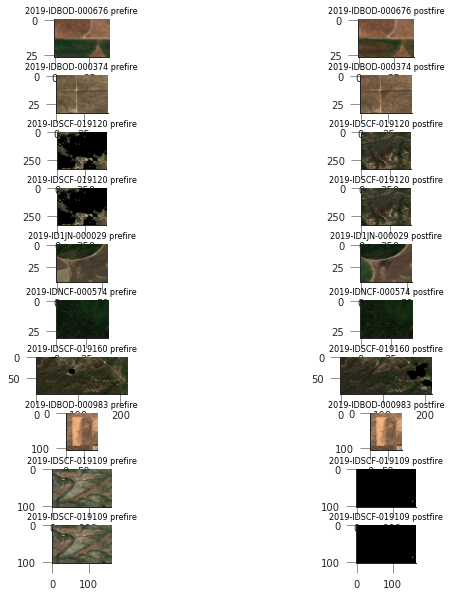

In [3]:
fig, axs = plt.subplots(nrows=10, ncols=2, figsize=(10, 10))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i, (fire_name, filename) in enumerate(zip(fire_names, filenames)):
        pre, post = filename
        g = gdal.Open(pre.as_posix())
        data_pre = g.ReadAsArray()
        g = gdal.Open(post.as_posix())
        data_post = g.ReadAsArray()
        axs[i, 0].imshow(3 * data_pre[[2, 1, 0], :, :].transpose((1, 2, 0)) / 10000)
        axs[i, 1].imshow(3 * data_post[[2, 1, 0], :, :].transpose((1, 2, 0)) / 10000)
        axs[i, 0].set_title(f"{fire_name} prefire", fontsize=8)
        axs[i, 1].set_title(f"{fire_name} postfire", fontsize=8)


## Calculating $fcc$

Once we have the pre- and post-fire, we can calculate $fcc$. We need the filenames for the pre and post fire reflectances:

In [18]:
import fire_impacts
s2_pref = "s2_data/2019-ID1JN-000029_prefire.tif"
s2_postf = "s2_data/2019-ID1JN-000029_postfire.tif"
obs = fire_impacts.GEEObservations(s2_pref, s2_postf)

calculator = fire_impacts.FireImpacts(obs)
calculator.launch_processor()

This results in two new files popping up in your folder: 
* `S2_2019-ID1JN-000029_prefire_pre_post_fcc.tif`: The file containing $fcc$, $a_0$ and $a_1$ (3 bands, in thar oder).
* `S2_2019-ID1JN-000029_prefire_pre_post_rmse.tif`. A file containing the RMSE of the model fit (single band, high values are useful to flag issues).

According to "the theory", fires are characterised by $fcc>0.2$ or thereabouts:

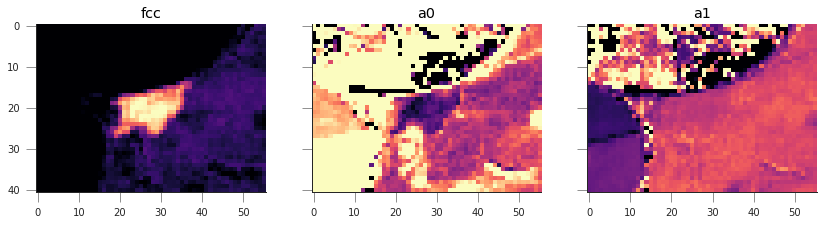

In [27]:
g = gdal.Open("S2_2019-ID1JN-000029_prefire_pre_post_fcc.tif")
data = g.ReadAsArray()
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True,
                        figsize=(14, 6))

vmins = [0.2, 0, 0]
vmaxs = [1.2, 0.1, 0.4]
for i,p in enumerate(["fcc", "a0", "a1"]):
    
    axs[i].imshow(data[i], vmin=vmins[i], vmax=vmaxs[i],
                  interpolation="nearest", cmap=plt.cm.magma)
    axs[i].set_title(p)